In [2]:
#导入用到的包
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [45]:
#导入数据
def load_dataset():
    train_dataset = h5py.File("train_cat.h5","r") #读取训练数据，共209张图片
    test_dataset = h5py.File("test_cat.h5", "r") #读取测试数据，共50张图片
    
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) #原始训练集（209*64*64*3）
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) #原始训练集的标签集（y=0非猫,y=1是猫）（209*1）
    
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) #原始测试集（50*64*64*3
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) #原始测试集的标签集（y=0非猫,y=1是猫）（50*1）
    
    train_set_y_orig = train_set_y_orig.reshape((1,train_set_y_orig.shape[0])) #原始训练集的标签集设为（1*209）
    test_set_y_orig = test_set_y_orig.reshape((1,test_set_y_orig.shape[0])) #原始测试集的标签集设为（1*50）
    
    classes = np.array(test_dataset["list_classes"][:])
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [56]:
#显示图片
def image_show(index,dataset):
    index = index
    if dataset == "train":
        plt.imshow(train_set_x_orig[index])
        print ("y = " + str(train_set_y[:, index]) + ", 它是一张" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' 图片。")
    elif dataset == "test":
        plt.imshow(test_set_x_orig[index])
        print ("y = " + str(test_set_y[:, index]) + ", 它是一张" + classes[np.squeeze(test_set_y[:, index])].decode("utf-8") +  "' 图片。")


In [73]:
#sigmoid函数
def sigmoid(z):
    s = 1.0/(1+np.exp(-z))
    return s

In [74]:
#初始化参数w,b
def initialize_with_zeros(dim):
    w = np.zeros((dim,1)) #w为一个dim*1矩阵
    b = 0    
    return w, b

In [75]:
#计算Y_hat,成本函数J以及dw，db
def propagate(w, b, X, Y):
    m = X.shape[1] #样本个数
    Y_hat = sigmoid(np.dot(w.T,X)+b)                                     
    cost = -(np.sum(np.dot(Y,np.log(Y_hat).T)+np.dot((1-Y),np.log(1-Y_hat).T)))/m #成本函数
    
    dw = (np.dot(X,(Y_hat-Y).T))/m
    db = (np.sum(Y_hat-Y))/m

    cost = np.squeeze(cost) #压缩维度    
    grads = {"dw": dw,
             "db": db} #梯度
    
    return grads, cost

In [76]:
#梯度下降找出最优解
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):#num_iterations-梯度下降次数 learning_rate-学习率，即参数ɑ
    costs = [] #记录成本值
    
    for i in range(num_iterations): #循环进行梯度下降
        grads, cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        if i % 100 == 0: #每100次记录一次成本值
            costs.append(cost)
        
        if print_cost and i % 100 == 0: #打印成本值
            print ("循环%i次后的成本值: %f" %(i, cost))
    
    params = {"w": w,
              "b": b} #最终参数值
    
    grads = {"dw": dw,
             "db": db}#最终梯度值
    
    return params, grads, costs

In [77]:
#预测出结果
def predict(w, b, X):
    m = X.shape[1] #样本个数
    Y_prediction = np.zeros((1,m)) #初始化预测输出
    w = w.reshape(X.shape[0], 1) #转置参数向量w
    
    Y_hat = sigmoid(np.dot(w.T,X)+b) #最终得到的参数代入方程
    
    for i in range(Y_hat.shape[1]):
        if Y_hat[:,i]>0.5:
            Y_prediction[:,i] = 1
        else:
            Y_prediction[:,i] = 0
    
    return Y_prediction

In [78]:
#建立整个预测模型
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False): #num_iterations-梯度下降次数 learning_rate-学习率，即参数ɑ
    w, b = initialize_with_zeros(X_train.shape[0]) #初始化参数w，b

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost) #梯度下降找到最优参数
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_train = predict(w, b, X_train) #训练集的预测结果
    Y_prediction_test = predict(w, b, X_test) #测试集的预测结果
    
    train_accuracy = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100 #训练集识别准确度
    test_accuracy = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100 #测试集识别准确度
    
    print("训练集识别准确度: {} %".format(train_accuracy))
    print("测试集识别准确度: {} %".format(test_accuracy))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [79]:
#初始化数据
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

m_train = train_set_x_orig.shape[0] #训练集中样本个数
m_test = test_set_x_orig.shape[0] #测试集总样本个数
num_px = test_set_x_orig.shape[1] #图片的像素大小

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T #原始训练集的设为（12288*209）
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T #原始测试集设为（12288*50）

train_set_x = train_set_x_flatten/255. #将训练集矩阵标准化
test_set_x = test_set_x_flatten/255. #将测试集矩阵标准化

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

循环0次后的成本值: 0.693147
循环100次后的成本值: 0.584508
循环200次后的成本值: 0.466949
循环300次后的成本值: 0.376007
循环400次后的成本值: 0.331463
循环500次后的成本值: 0.303273
循环600次后的成本值: 0.279880
循环700次后的成本值: 0.260042
循环800次后的成本值: 0.242941
循环900次后的成本值: 0.228004
循环1000次后的成本值: 0.214820
循环1100次后的成本值: 0.203078
循环1200次后的成本值: 0.192544
循环1300次后的成本值: 0.183033
循环1400次后的成本值: 0.174399
循环1500次后的成本值: 0.166521
循环1600次后的成本值: 0.159305
循环1700次后的成本值: 0.152667
循环1800次后的成本值: 0.146542
循环1900次后的成本值: 0.140872
训练集识别准确度: 99.04306220095694 %
测试集识别准确度: 70.0 %


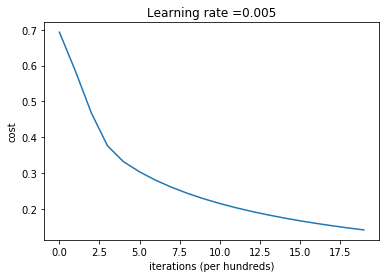

In [80]:
# 画出学习曲线
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

学习率: 0.01
训练集识别准确度: 99.52153110047847 %
测试集识别准确度: 68.0 %

-------------------------------------------------------

学习率: 0.001
训练集识别准确度: 88.99521531100478 %
测试集识别准确度: 64.0 %

-------------------------------------------------------

学习率: 0.0001
训练集识别准确度: 68.42105263157895 %
测试集识别准确度: 36.0 %

-------------------------------------------------------



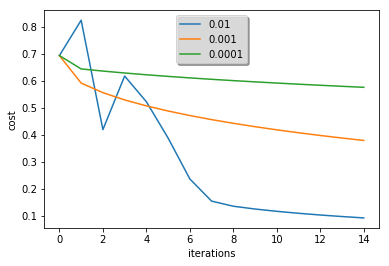

In [69]:
#学习率不同时的学习曲线
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("学习率: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

y = 0.0, your algorithm predicts a "non-cat" picture.


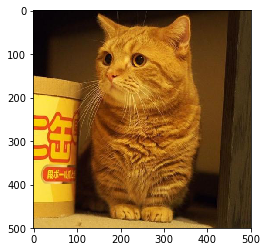

In [87]:
#使用自己的图片测试这个猫识别器
fname = "my_image.jpg"   #改成自己的图片文件名 

image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")